## Import libraries

In [29]:
import sys
import os
import shutil
sys.path.append(os.path.abspath(".."))

import json

from tqdm import tqdm

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from models.resnet import ResNet
from models.mlp import MLP

### Relative path of data

In [2]:
train_data_path = r'..\\..\\dataset_landmarks\\train'
test_data_path = r'..\\..\\dataset_landmarks\\test'
numeric_data_path = r'..\\..\\np_features'
dataset_group_path_train = r'..\\..\\dataset_grouped\\train'
dataset_group_path_test = r'..\\..\\dataset_grouped\\test'

### Display one sample of image

(310, 310)


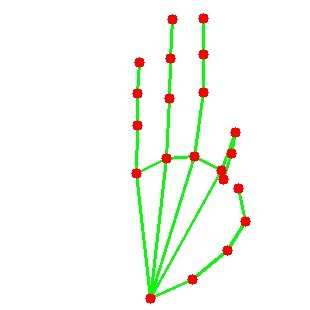

In [3]:
image = Image.open(os.path.join(train_data_path, 'F\\10.jpg'))
print(image.size)
image

## Labels
Our ResNet model will predict the group of similar signs for example `group 0` can be `[a, m, n, s, t, e]` which are very similar and then some simple neural networks will predict the final label using the numeric features

### Groups:
- [a, m, n, s, t, e] -> 0
- [d, f, b, u, v, l, k, r, w] -> 1
- [g, h, y, j , i] -> 2
- [c, o, p, q, z, x] -> 3
- space -> 4
- backspace -> 5

In [14]:
os.makedirs(dataset_group_path_train, exist_ok=True)
os.makedirs(dataset_group_path_test, exist_ok=True)

group_lists = [
    ['A', 'M', 'N', 'S', 'T', 'E'],
    ['D', 'F', 'B', 'U', 'V', 'L', 'K', 'R', 'W'],
    ['G', 'H', 'Y', 'J', 'I'],
    ['C', 'O', 'P', 'Q', 'Z', 'X']
]
dataset_group_list = [dataset_group_path_train, dataset_group_path_test]

In [ ]:
for dataset_group_path in dataset_group_list:
    for group in tqdm(group_lists):
        group_folder = ''.join(group)
        destination = os.path.join(dataset_group_path, group_folder)
        os.makedirs(destination, exist_ok=True)
        for folder in group:
            if dataset_group_path.endswith('train'):
                data_path = train_data_path
            else:
                data_path = test_data_path
            folder_to_search = os.path.join(data_path, folder)
            if os.path.exists(folder_to_search):
                for file in os.listdir(folder_to_search):
                    if file.endswith('.jpg'):
                        src_path = os.path.join(folder_to_search, file)
                        dest_path = os.path.join(destination, f'{folder}_{file}')
                        shutil.copy(src_path, dest_path)

specials = ['space', 'backspace']

for dataset_group_path in dataset_group_list:
    for special in tqdm(specials):
        destination = os.path.join(dataset_group_path, special)
        os.makedirs(destination, exist_ok=True)
        if dataset_group_path.endswith('train'):
            data_path = train_data_path
        else:
            data_path = test_data_path
        src_folder = os.path.join(data_path, special)
        if os.path.exists(src_folder):
            for file in os.listdir(src_folder):
                if file.endswith('.jpg'):
                    src_path = os.path.join(src_folder, file)
                    dest_path = os.path.join(destination, f'{special}_{file}')
                    shutil.copy(src_path, dest_path)

100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


# PHASE 1

in this phase we train the CNN model to predict the group

## Load Data

Loading train and test dataset using `ImageFolder` from `pytorch datasets` module

__Imagefolder__: A generic data loader where the images are arranged in this way by default:
                 `folder/class1/(images files)`, `folder/class2/(images files)`

## Transforms

1. __Resize__: Resizes images that are 300x300 to 128x128 for better computation

2. __Grayscale__: Since our images have processed during the data creation and for hand gestures hand shape and edges matter more than color we consider grayscale for images and move from 3 channels images to 1 channel

3. __ToTensor__: Transforms images from PIL images to pytorch tensors

4. __Normalize__: It makes training more stable by standardizing the data distribution and if some images are brighter/darker, normalization reduces their impact and also if images have varying intensity ranges, normalization ensures they follow a similar distribution.

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # (3, 300, 300) -> (3, 128, 128)
    # transforms.Grayscale(num_output_channels=1), # (3, 128, 128) -> grayscale and (1, 128, 128)
    transforms.ToTensor(), # transform from PIL to Tensor
    transforms.Normalize(mean=[0.947], std=[0.177]) # (Image - mean) / std
])

train_dataset = datasets.ImageFolder(root=dataset_group_path_train, transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_group_path_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [5]:
batch_images, batch_labels = next(iter(train_dataloader))
print(f'training data shape: images -> {batch_images.shape}, labels -> {batch_labels.shape}')

training data shape: images -> torch.Size([64, 3, 128, 128]), labels -> torch.Size([64])


In [5]:
train_dataset.classes

['AMNSTE', 'COPQZX', 'DFBUVLKRW', 'GHYJI', 'backspace', 'space']

set device to move tensors and model to GPU for faster computation

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Define model

In this section, we define the ResNet model architecture and initialize the optimizer and loss function.

- **Model Definition**: We use a custom ResNet model with the following layers:
    - Convolutional layers and Residual blocks with ReLU activation and Batch Normalization.
    - MaxPooling layers to reduce the spatial dimensions.
    - Fully connected layers with Dropout for regularization.

- **Optimizer**: We use the AdamW optimizer with a learning rate of 0.0001 and weight decay of 1e-4.

- **Loss Function**: We use CrossEntropyLoss, which is suitable for multi-class classification tasks.

The model is moved to the GPU (if available) for faster computation.

In [7]:
model = ResNet(in_channels=3).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1): ResBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res2): ResBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_

## Training and Evaluating phase of model

Training model on 7 epochs and saving the `train losses`, `test losses` and `test accuracies` for each epoch

In [8]:
train_losses = []
test_losses = []
test_accuracies = []

epochs = 5

for epoch in tqdm(range(epochs)):
    # Training phase
    model.train()
    epoch_loss = 0
    num_train_batches = len(train_dataloader)

    for i, (img, label) in enumerate(train_dataloader):
        img, label = img.to(device), label.to(device) # Move images to device

        logits = model(img) # Predict logits (Batch size, 29)
        loss: Tensor = loss_fn(logits, label) # Calculate loss

        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / num_train_batches
    train_losses.append(avg_train_loss)

    # Test phase (eval phase)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    num_test_batches = len(test_dataloader)

    with torch.no_grad():
        for img, label in test_dataloader:
            img, label = img.to(device), label.to(device) # Move images to device

            logits = model(img) # Predict logits (Batch size, 29)
            loss: Tensor = loss_fn(logits, label) # Calculate loss
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(logits, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    avg_test_loss = test_loss / num_test_batches
    test_accuracy = correct / total * 100
    test_losses.append(avg_test_loss)
    
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{epochs} - Avg Train Loss: {avg_train_loss:.4f}')
    print(f'Epoch {epoch+1}/{epochs} - Avg Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

 20%|██        | 1/5 [02:08<08:32, 128.14s/it]

Epoch 1/5 - Avg Train Loss: 0.5088
Epoch 1/5 - Avg Test Loss: 0.0246, Accuracy: 99.65%


 40%|████      | 2/5 [03:13<04:34, 91.36s/it] 

Epoch 2/5 - Avg Train Loss: 0.0176
Epoch 2/5 - Avg Test Loss: 0.1161, Accuracy: 97.03%


 60%|██████    | 3/5 [04:21<02:41, 80.53s/it]

Epoch 3/5 - Avg Train Loss: 0.0062
Epoch 3/5 - Avg Test Loss: 0.0754, Accuracy: 97.81%


 80%|████████  | 4/5 [05:31<01:16, 76.33s/it]

Epoch 4/5 - Avg Train Loss: 0.0023
Epoch 4/5 - Avg Test Loss: 0.0222, Accuracy: 99.57%


100%|██████████| 5/5 [06:40<00:00, 80.09s/it]

Epoch 5/5 - Avg Train Loss: 0.0024
Epoch 5/5 - Avg Test Loss: 0.0185, Accuracy: 99.37%


Saving the model

In [10]:
torch.save(model.state_dict(), '..\\..\\weights\\group_predictor_weights.pth')

### Plot loss and accuracy of the model for each epoch

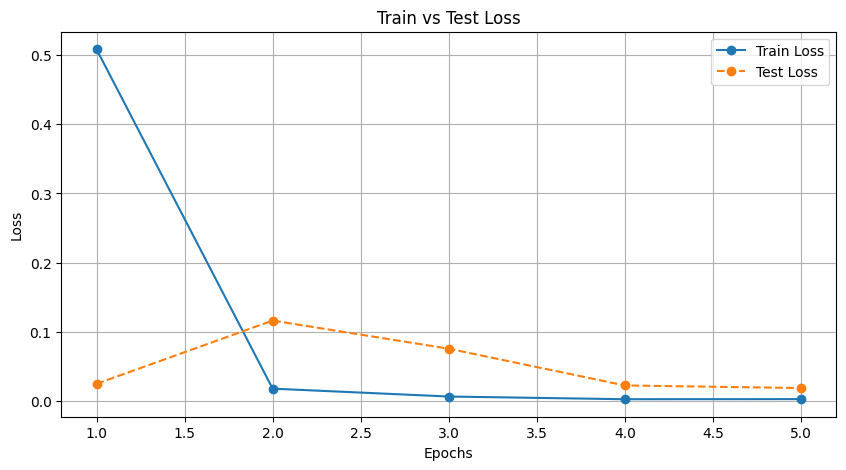

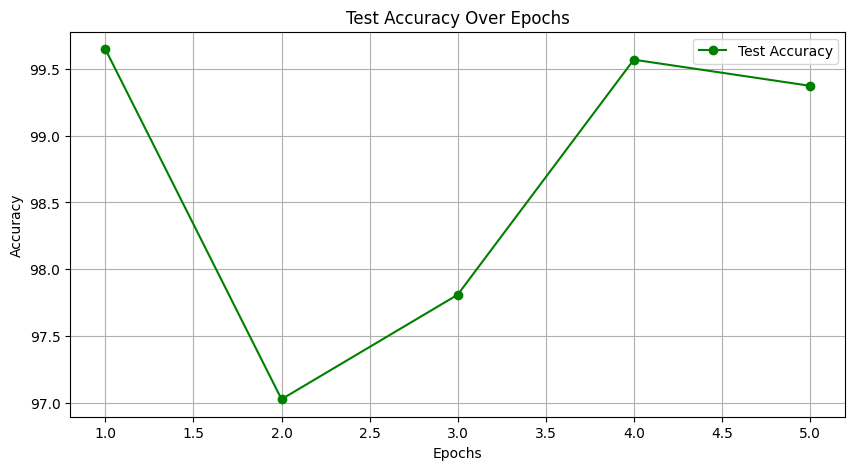

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# PHASE 2
Training simple neural networks on landmarks features

### Create groups

First of all we have to create numpy data for each group:
- [a, m, n, s, t, e] -> 0
- [d, f, b, u, v, l, k, r, w] -> 1
- [g, h, y, j , i] -> 2
- [c, o, p, q, z, x] -> 3

Load numeric data from collected data

In [5]:
full_data_path = os.path.join(numeric_data_path, 'numeric_data.npy')
numeric_data = np.load(full_data_path)

Group numeric data

In [ ]:
groups = [['a', 'm', 'n', 's', 't', 'e'], 
          ['d', 'f', 'b', 'u', 'v', 'l', 'k', 'r', 'w'], 
          ['g', 'h', 'y', 'j', 'i'], 
          ['c', 'o', 'p', 'q', 'z', 'x']]

for group in groups:
    group_name = ''.join(group)
    group_data = np.empty((0, 16))
    saved_name = os.path.join(numeric_data_path, group_name)
    for letter in group:
        ascii_code = ord(letter)
        letter_data = numeric_data[numeric_data[:, 15] == ascii_code]
        group_data = np.vstack([group_data, letter_data])
    np.save(saved_name, group_data)

### create Dataset and dataloader for each group

Since pytorch expects labels to be encoded from 0 to N-1 we need to encode ascii codes to labels 0 to N-1

In [33]:
# A dict to save data for each group
data_groups = {}

for group in groups:
    group_name = ''.join(group)
    data_groups[group_name] = torch.from_numpy(np.array(np.load(os.path.join(numeric_data_path, f'{group_name}.npy')), dtype=np.float32))

# A dict to create dataloader for each group
dataloaders = {}

# Collecting encoded labels
training_labels = {}

for name, data in data_groups.items():
    X = data[:, :-1]
    y = data[:, -1].long()

    # Encode labels and add to training_labels dict
    unique_labels = torch.unique(y)
    label_indx = {ascii_code.item(): encode for encode, ascii_code in enumerate(unique_labels)}
    training_labels[name] = label_indx
    encoded_y = torch.tensor([label_indx[ascii_code.item()] for ascii_code in y])

    # Create dataset and DataLoader using TensorDataset
    dataset = TensorDataset(X, encoded_y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    dataloaders[name] = dataloader

# Save encoded labels as json
with open('../labels.json', 'w') as file:
    json.dump(training_labels, file, indent=4)

### Defining 4 different model and their optimizers for each group 

In [25]:
lr = 0.01

mlp_amnste = MLP(15, 6).to(device)
mlp_dfbuvlkrw = MLP(15, 9).to(device)
mlp_copqzx = MLP(15, 6).to(device)
mlp_ghyji = MLP(15, 5).to(device)

models = {
    'amnste': mlp_amnste,
    'dfbuvlkrw': mlp_dfbuvlkrw,
    'ghyji': mlp_ghyji,
    'copqzx': mlp_copqzx,
}

optimizers = {}

for name, model in models.items():
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    optimizers[name] = optimizer

loss_fn = nn.CrossEntropyLoss()

### Train the models on their own group data

In [26]:
epochs = 30

for model, optimizer, dataloader in zip(models.values(), optimizers.values(), dataloaders.values()):
    model.train()
    total_loss = 0
    for epoch in tqdm(pbar := range(epochs)):
        for X, y in dataloader:
            batch_size = len(dataloader)
            X, y = X.to(device), y.to(device)
            logits = model(X)

            loss = loss_fn(logits, y)
            total_loss += loss.item() / batch_size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    print(total_loss)

100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


0.46677061387942664


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


0.738228346413653


100%|██████████| 30/30 [00:04<00:00,  6.39it/s]


0.7061112555581127


100%|██████████| 30/30 [00:06<00:00,  4.79it/s]

0.5359123496010783


Save the weights of each model

In [ ]:
for name, model in models.items():
    torch.save(model.state_dict(), f'../../weights/{name}_weights.pth')

AttributeError: 'dict' object has no attribute 'item'